# 🧠 Entraînement du Modèle ResNet sur CIFAR-10

**Projet Deep Learning - Classification d'Images**

**Étudiant**: Ahmed Belhareth

**Module**: Deep Learning - Computer Vision

---

Ce notebook entraîne un modèle ResNet-18 pré-entraîné sur le dataset CIFAR-10 avec augmentation de données.

## 1. Configuration de l'Environnement

In [1]:
# Installation des dépendances (décommenter pour Google Colab)
# !pip install torch torchvision timm mlflow matplotlib seaborn tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # auto détecte notebook vs console
import mlflow
import mlflow.pytorch
from pathlib import Path
import time
import json

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Vérifier GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cpu


## 2. Configuration des Hyperparamètres

In [3]:
# Hyperparamètres
CONFIG = {
    'model_name': 'resnet18',
    'pretrained': True,
    'num_classes': 10,
    'batch_size': 128,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'dropout_rate': 0.2,
    'val_split': 0.1,
    'early_stopping_patience': 10,
    'seed': 42
}

# Classes CIFAR-10
CLASSES = [
    'Avion', 'Automobile', 'Oiseau', 'Chat', 'Cerf',
    'Chien', 'Grenouille', 'Cheval', 'Navire', 'Camion'
]

# Normalisation CIFAR-10
CIFAR10_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR10_STD = [0.2470, 0.2435, 0.2616]

# Seed pour reproductibilité
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  model_name: resnet18
  pretrained: True
  num_classes: 10
  batch_size: 128
  num_epochs: 30
  learning_rate: 0.001
  weight_decay: 0.0001
  dropout_rate: 0.2
  val_split: 0.1
  early_stopping_patience: 10
  seed: 42


## 3. Préparation des Données

In [4]:
# Transformations d'entraînement avec augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    transforms.RandomErasing(p=0.1)
])

# Transformations de test (sans augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD)
])

# Charger les datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Diviser train en train/val
train_size = int((1 - CONFIG['val_split']) * len(train_dataset))
val_size = len(train_dataset) - train_size

generator = torch.Generator().manual_seed(CONFIG['seed'])
train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

print(f"Taille entraînement: {len(train_subset)}")
print(f"Taille validation: {len(val_subset)}")
print(f"Taille test: {len(test_dataset)}")

Taille entraînement: 45000
Taille validation: 5000
Taille test: 10000


In [5]:
# Créer les DataLoaders
# Note: num_workers=0 pour compatibilité Windows
train_loader = DataLoader(
    train_subset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_subset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

print(f"Batches d'entraînement: {len(train_loader)}")
print(f"Batches de validation: {len(val_loader)}")
print(f"Batches de test: {len(test_loader)}")

Batches d'entraînement: 352
Batches de validation: 40
Batches de test: 79


## 4. Création du Modèle

In [6]:
class CIFAR10ResNet(nn.Module):
    """Modèle ResNet adapté pour CIFAR-10."""
    
    def __init__(self, model_name='resnet18', num_classes=10, pretrained=True, dropout_rate=0.2):
        super().__init__()
        
        # Charger le modèle pré-entraîné
        if model_name == 'resnet18':
            weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            self.backbone = models.resnet18(weights=weights)
        elif model_name == 'resnet34':
            weights = models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
            self.backbone = models.resnet34(weights=weights)
        else:
            raise ValueError(f"Modèle non supporté: {model_name}")
        
        # Remplacer la tête de classification
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, num_classes)
        )
        
        self.model_name = model_name
        self.num_classes = num_classes
    
    def forward(self, x):
        return self.backbone(x)
    
    def count_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total, trainable

# Créer le modèle
model = CIFAR10ResNet(
    model_name=CONFIG['model_name'],
    num_classes=CONFIG['num_classes'],
    pretrained=CONFIG['pretrained'],
    dropout_rate=CONFIG['dropout_rate']
)
model = model.to(device)

# Afficher les informations
total_params, trainable_params = model.count_parameters()
print(f"Modèle: {CONFIG['model_name']}")
print(f"Paramètres totaux: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")

Modèle: resnet18
Paramètres totaux: 11,181,642
Paramètres entraînables: 11,181,642


## 5. Fonctions d'Entraînement

In [7]:
class EarlyStopping:
    """Early stopping pour éviter le surapprentissage."""
    
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop


def train_one_epoch(model, loader, criterion, optimizer, device):
    """Entraîne le modèle pour une époque."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Train", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    return running_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    """Évalue le modèle sur le dataset de validation."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

## 6. Entraînement du Modèle

In [8]:
# Critère et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['num_epochs'])
early_stopping = EarlyStopping(patience=CONFIG['early_stopping_patience'])

# Historique
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_model_path = './best_model.pth'

# Configuration MLflow
mlflow.set_experiment("CIFAR10_Classification")

print(f"\n{'='*60}")
print(f"Début de l'entraînement sur {device}")
print(f"{'='*60}\n")

2025/12/15 16:28:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...


2025/12/15 16:28:48 INFO mlflow.store.db.utils: Updating database tables


2025/12/15 16:28:48 INFO alembic.runtime.migration: Context impl SQLiteImpl.


2025/12/15 16:28:48 INFO alembic.runtime.migration: Will assume non-transactional DDL.


2025/12/15 16:28:48 INFO alembic.runtime.migration: Context impl SQLiteImpl.


2025/12/15 16:28:48 INFO alembic.runtime.migration: Will assume non-transactional DDL.



Début de l'entraînement sur cpu



In [9]:
# Boucle d'entraînement
start_time = time.time()

with mlflow.start_run():
    # Logger les hyperparamètres
    mlflow.log_params(CONFIG)
    
    for epoch in range(CONFIG['num_epochs']):
        # Entraînement
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Learning rate
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        
        # Sauvegarder l'historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Afficher les résultats
        print(f"Époque {epoch+1}/{CONFIG['num_epochs']}")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Valid - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"  LR: {current_lr:.6f}")
        
        # Logger dans MLflow
        mlflow.log_metrics({
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'learning_rate': current_lr
        }, step=epoch)
        
        # Sauvegarder le meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': CONFIG
            }, best_model_path)
            print(f"  ✓ Meilleur modèle sauvegardé (acc: {val_acc:.2f}%)")
        
        # Early stopping
        if early_stopping(val_loss):
            print(f"\n⚠ Early stopping à l'époque {epoch+1}")
            break
        
        print()
    
    # Logger le modèle final
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_metric('best_val_acc', best_val_acc)

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"Entraînement terminé en {total_time/60:.2f} minutes")
print(f"Meilleure accuracy de validation: {best_val_acc:.2f}%")
print(f"{'='*60}")

C:\Users\Moe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 1/30
  Train - Loss: 1.1408, Acc: 60.79%
  Valid - Loss: 1.1138, Acc: 61.60%
  LR: 0.001000
  ✓ Meilleur modèle sauvegardé (acc: 61.60%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 2/30
  Train - Loss: 0.8500, Acc: 71.16%
  Valid - Loss: 0.8655, Acc: 71.10%
  LR: 0.000997
  ✓ Meilleur modèle sauvegardé (acc: 71.10%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 3/30
  Train - Loss: 0.7332, Acc: 74.80%
  Valid - Loss: 0.7396, Acc: 73.98%
  LR: 0.000989
  ✓ Meilleur modèle sauvegardé (acc: 73.98%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 4/30
  Train - Loss: 0.6877, Acc: 76.46%
  Valid - Loss: 0.8270, Acc: 71.90%
  LR: 0.000976



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 5/30
  Train - Loss: 0.6354, Acc: 78.13%
  Valid - Loss: 0.6831, Acc: 77.38%
  LR: 0.000957
  ✓ Meilleur modèle sauvegardé (acc: 77.38%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 6/30
  Train - Loss: 0.6133, Acc: 78.98%
  Valid - Loss: 0.6459, Acc: 77.54%
  LR: 0.000933
  ✓ Meilleur modèle sauvegardé (acc: 77.54%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 7/30
  Train - Loss: 0.5683, Acc: 80.59%
  Valid - Loss: 0.6245, Acc: 78.68%
  LR: 0.000905
  ✓ Meilleur modèle sauvegardé (acc: 78.68%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 8/30
  Train - Loss: 0.5398, Acc: 81.57%
  Valid - Loss: 0.5949, Acc: 78.78%
  LR: 0.000872
  ✓ Meilleur modèle sauvegardé (acc: 78.78%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 9/30
  Train - Loss: 0.5089, Acc: 82.55%
  Valid - Loss: 0.6073, Acc: 78.76%
  LR: 0.000835



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 10/30
  Train - Loss: 0.4858, Acc: 83.30%
  Valid - Loss: 0.5529, Acc: 80.84%
  LR: 0.000794
  ✓ Meilleur modèle sauvegardé (acc: 80.84%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 11/30
  Train - Loss: 0.4571, Acc: 84.32%
  Valid - Loss: 0.5922, Acc: 79.16%
  LR: 0.000750



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 12/30
  Train - Loss: 0.4476, Acc: 84.61%
  Valid - Loss: 0.5426, Acc: 81.20%
  LR: 0.000703
  ✓ Meilleur modèle sauvegardé (acc: 81.20%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 13/30
  Train - Loss: 0.4240, Acc: 85.36%
  Valid - Loss: 0.5133, Acc: 82.52%
  LR: 0.000655
  ✓ Meilleur modèle sauvegardé (acc: 82.52%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 14/30
  Train - Loss: 0.4004, Acc: 86.24%
  Valid - Loss: 0.5109, Acc: 82.12%
  LR: 0.000604



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 15/30
  Train - Loss: 0.3821, Acc: 86.80%
  Valid - Loss: 0.4880, Acc: 82.78%
  LR: 0.000552
  ✓ Meilleur modèle sauvegardé (acc: 82.78%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 16/30
  Train - Loss: 0.3573, Acc: 87.72%
  Valid - Loss: 0.4967, Acc: 82.94%
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé (acc: 82.94%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 17/30
  Train - Loss: 0.3446, Acc: 87.94%
  Valid - Loss: 0.4868, Acc: 83.20%
  LR: 0.000448
  ✓ Meilleur modèle sauvegardé (acc: 83.20%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 18/30
  Train - Loss: 0.3244, Acc: 88.73%
  Valid - Loss: 0.4556, Acc: 84.24%
  LR: 0.000396
  ✓ Meilleur modèle sauvegardé (acc: 84.24%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 19/30
  Train - Loss: 0.3089, Acc: 89.25%
  Valid - Loss: 0.4598, Acc: 84.10%
  LR: 0.000345



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 20/30
  Train - Loss: 0.2907, Acc: 89.77%
  Valid - Loss: 0.4598, Acc: 84.58%
  LR: 0.000297
  ✓ Meilleur modèle sauvegardé (acc: 84.58%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 21/30
  Train - Loss: 0.2682, Acc: 90.73%
  Valid - Loss: 0.4546, Acc: 84.86%
  LR: 0.000250
  ✓ Meilleur modèle sauvegardé (acc: 84.86%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 22/30
  Train - Loss: 0.2599, Acc: 90.97%
  Valid - Loss: 0.4488, Acc: 85.12%
  LR: 0.000206
  ✓ Meilleur modèle sauvegardé (acc: 85.12%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 23/30
  Train - Loss: 0.2427, Acc: 91.57%
  Valid - Loss: 0.4557, Acc: 85.24%
  LR: 0.000165
  ✓ Meilleur modèle sauvegardé (acc: 85.24%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 24/30
  Train - Loss: 0.2287, Acc: 91.88%
  Valid - Loss: 0.4719, Acc: 84.38%
  LR: 0.000128



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 25/30
  Train - Loss: 0.2228, Acc: 92.35%
  Valid - Loss: 0.4447, Acc: 85.26%
  LR: 0.000095
  ✓ Meilleur modèle sauvegardé (acc: 85.26%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 26/30
  Train - Loss: 0.2160, Acc: 92.42%
  Valid - Loss: 0.4296, Acc: 85.94%
  LR: 0.000067
  ✓ Meilleur modèle sauvegardé (acc: 85.94%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 27/30
  Train - Loss: 0.2061, Acc: 92.77%
  Valid - Loss: 0.4272, Acc: 86.22%
  LR: 0.000043
  ✓ Meilleur modèle sauvegardé (acc: 86.22%)



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 28/30
  Train - Loss: 0.2000, Acc: 93.09%
  Valid - Loss: 0.4426, Acc: 85.70%
  LR: 0.000024



Train:   0%|          | 0/352 [00:00<?, ?it/s]

Époque 29/30
  Train - Loss: 0.1972, Acc: 93.05%
  Valid - Loss: 0.4486, Acc: 85.26%
  LR: 0.000011



Train:   0%|          | 0/352 [00:00<?, ?it/s]

2025/12/15 16:52:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Époque 30/30
  Train - Loss: 0.1968, Acc: 93.21%
  Valid - Loss: 0.4233, Acc: 86.10%
  LR: 0.000003




Entraînement terminé en 23.52 minutes
Meilleure accuracy de validation: 86.22%


## 7. Visualisation de l'Entraînement

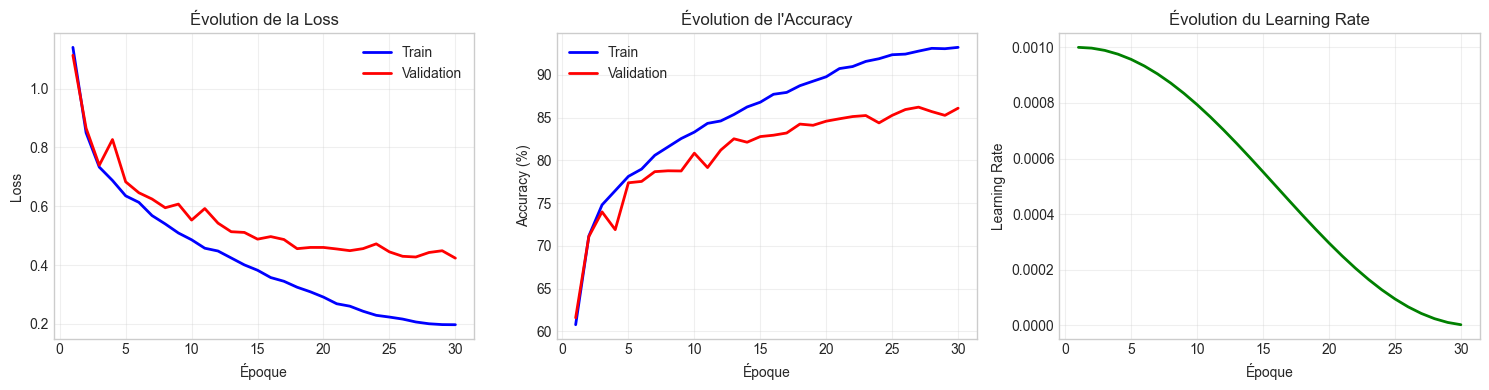

In [10]:
# Visualiser l'historique d'entraînement
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_title('Évolution de la Loss', fontsize=12)
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_title('Évolution de l\'Accuracy', fontsize=12)
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
axes[2].set_title('Évolution du Learning Rate', fontsize=12)
axes[2].set_xlabel('Époque')
axes[2].set_ylabel('Learning Rate')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

## 8. Sauvegarde des Résultats

In [11]:
# Sauvegarder l'historique
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Résumé
summary = {
    'config': CONFIG,
    'best_val_acc': best_val_acc,
    'total_epochs': len(history['train_loss']),
    'training_time_minutes': total_time / 60,
    'final_train_loss': history['train_loss'][-1],
    'final_val_loss': history['val_loss'][-1],
    'device': str(device)
}

with open('training_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ Entraînement terminé!")
print(f"\nRésumé:")
print(f"  Meilleure accuracy: {best_val_acc:.2f}%")
print(f"  Époques complétées: {len(history['train_loss'])}")
print(f"  Temps total: {total_time/60:.2f} min")
print(f"\nFichiers sauvegardés:")
print(f"  - best_model.pth")
print(f"  - training_history.json")
print(f"  - training_summary.json")
print(f"  - training_history.png")

✅ Entraînement terminé!

Résumé:
  Meilleure accuracy: 86.22%
  Époques complétées: 30
  Temps total: 23.52 min

Fichiers sauvegardés:
  - best_model.pth
  - training_history.json
  - training_summary.json
  - training_history.png
